## to do ...

### Arima/

### Is Data Stationary?

# Import Packages and Load Data

In [1]:
# colab only
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import warnings; 
warnings.simplefilter('ignore')

In [3]:
# data cleaning 
import pandas as pd
import datetime as dt
import numpy as np

# visualizations
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [4]:
# modelling - prophet
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics


# modelling - other
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [5]:
# adjust settings 
sns.set_theme(style='whitegrid', context='talk')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# load data

In [6]:
df_full = pd.read_csv('data/data_full_clean.csv', index_col=0)
df_full.head()

Period                                          Commodity  \
0  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
1  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
2  2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
3  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
4  2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   

                    Province        Country          State  Quantity_kg  \
0  Newfoundland and Labrador  United States  Massachusetts        42059   
1              New Brunswick  United States  Massachusetts       370393   
2       Prince Edward Island  United States     California         1633   
3                     Quebec  United States     California         2347   
4       Prince Edward Island  United States  New Hampshire        15676   

   Value-adjusted  year               GDP-USD continent  
0    3,023,516.55  2017 19,477,336,549,000.00  Americas  
1   24,808,298.71  2017 19,477,336,549,000.00  Americas  
2       38,330.44  2017 19,477,336,549,000.00  Americas  
3      121,476.42  2017 19,477,336,549,000.00  Americas  
4      383,038.25  2017 19,477,336,549,000.00  Americas

In [7]:
# filter data only for USA countries
model_data = df_full[df_full['Country'].str.contains('United States')]
model_data

Period                                          Commodity  \
0      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
1      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
2      2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
3      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
4      2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
...           ...                                                ...   
54047  1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   
54048  1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54049  1990-04-01  0306.22.90 - lobsters,(homarus spp), not froze...   
54050  1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54051  1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   

                        Province        Country          State  Quantity_kg  \
0      Newfoundland and Labrador  United States  Massachusetts        42059   
1                  New Brunswick  United States  Massachusetts       370393   
2           Prince Edward Island  United States     California         1633   
3                         Quebec  United States     California         2347   
4           Prince Edward Island  United States  New Hampshire        15676   
...                          ...            ...            ...          ...   
54047                Nova Scotia  United States          Maine       495399   
54048                Nova Scotia  United States  Massachusetts        22653   
54049              New Brunswick  United States  Massachusetts          998   
54050                     Quebec  United States  Massachusetts        92640   
54051                     Quebec  United States  Massachusetts         1361   

       Value-adjusted  year               GDP-USD continent  
0        3,023,516.55  2017 19,477,336,549,000.00  Americas  
1       24,808,298.71  2017 19,477,336,549,000.00  Americas  
2           38,330.44  2017 19,477,336,549,000.00  Americas  
3          121,476.42  2017 19,477,336,549,000.00  Americas  
4          383,038.25  2017 19,477,336,549,000.00  Americas  
...               ...   ...                   ...       ...  
54047    7,596,544.89  1990  5,963,144,000,000.00  Americas  
54048      967,469.26  1990  5,963,144,000,000.00  Americas  
54049        9,460.22  1990  5,963,144,000,000.00  Americas  
54050    1,441,995.60  1990  5,963,144,000,000.00  Americas  
54051       11,560.25  1990  5,963,144,000,000.00  Americas  

[26802 rows x 10 columns]

In [8]:
model_data['Period'] = pd.to_datetime(model_data['Period'])

# Feature Engg / Preprocessing

### Group Commodtiies by High/Mid/Low Volume
source:
https://github.com/priyalingutla/30-Days-Of-Data/blob/main/DAY%201%20Forecasting%20%2330daysofdata.ipynb

In [9]:
model_data

Period                                          Commodity  \
0     2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
1     2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
2     2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
3     2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
4     2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
...          ...                                                ...   
54047 1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   
54048 1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54049 1990-04-01  0306.22.90 - lobsters,(homarus spp), not froze...   
54050 1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54051 1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   

                        Province        Country          State  Quantity_kg  \
0      Newfoundland and Labrador  United States  Massachusetts        42059   
1                  New Brunswick  United States  Massachusetts       370393   
2           Prince Edward Island  United States     California         1633   
3                         Quebec  United States     California         2347   
4           Prince Edward Island  United States  New Hampshire        15676   
...                          ...            ...            ...          ...   
54047                Nova Scotia  United States          Maine       495399   
54048                Nova Scotia  United States  Massachusetts        22653   
54049              New Brunswick  United States  Massachusetts          998   
54050                     Quebec  United States  Massachusetts        92640   
54051                     Quebec  United States  Massachusetts         1361   

       Value-adjusted  year               GDP-USD continent  
0        3,023,516.55  2017 19,477,336,549,000.00  Americas  
1       24,808,298.71  2017 19,477,336,549,000.00  Americas  
2           38,330.44  2017 19,477,336,549,000.00  Americas  
3          121,476.42  2017 19,477,336,549,000.00  Americas  
4          383,038.25  2017 19,477,336,549,000.00  Americas  
...               ...   ...                   ...       ...  
54047    7,596,544.89  1990  5,963,144,000,000.00  Americas  
54048      967,469.26  1990  5,963,144,000,000.00  Americas  
54049        9,460.22  1990  5,963,144,000,000.00  Americas  
54050    1,441,995.60  1990  5,963,144,000,000.00  Americas  
54051       11,560.25  1990  5,963,144,000,000.00  Americas  

[26802 rows x 10 columns]

In [10]:
# sum of commodity by period

sum_exports = model_data[['Commodity', 'Value-adjusted']]
sum_exports = sum_exports.groupby(['Commodity']).sum().sort_values(by = 'Value-adjusted', ascending = False) 
sum_exports

Value-adjusted
Commodity                                                          
0306.22.10 - lobsters, (homarus spp), live (ter... 9,609,789,810.93
0306.12.90 - lobsters, nes, frozen                 7,799,288,252.14
0306.12.90 - lobsters, (homarus spp), nes, froz... 6,776,305,219.12
1605.30.11 - lobster meat, frozen, simply boile... 3,887,987,368.37
0306.32.10 - lobsters, live                        3,548,656,002.17
1605.30.10 - lobster, prepared or preserved, fr... 2,675,024,251.92
0306.22.10 - lobsters, live (terminated 2016-12)   2,608,109,328.45
1605.30.11 - lobster meat, frozen, cooked by st... 1,713,600,651.46
0306.12.10 - lobsters, in brine, frozen              477,278,652.64
0306.12.10 - lobsters in brine, (homarus spp), ...   306,984,114.31
1605.30.91 - lobster, prepared or preserved, in...   205,577,038.21
1605.30.99 - lobster, prepared or preserved, no...    97,842,111.65
1605.30.90 - lobster, prepared or preserved, nes      80,095,402.46
1605.30.19 - lobster meat, not frozen, simply b...    69,354,642.70
0306.22.90 - lobsters,(homarus spp), not frozen...    66,530,985.82
1605.30.19 - lobster meat, o/t frozen, cooked b...    55,460,620.88
1605.30.20 - lobster, prepared or preserved, in...    26,780,201.94
0306.32.90 - lobsters, fresh or chilled, o/t live     21,635,579.13
1605.30.99 - lobster, prepared or preserved, o/...    21,330,384.12
1605.30.12 - lobster meat, not frozen, simply b...    15,345,040.02
0306.22.90 - lobsters, not frozen, other than l...    11,563,359.42
0306.21.00 - rock lobster & other sea crawfish ...     7,230,841.59
0306.11.00 - rock lobster & other sea crawfish,...     6,140,141.90
1605.30.92 - lobster, prepared or preserved, no...     5,217,346.82
0306.11.00 - rock lobster & o sea crawfish,frz,...     4,654,551.69
0306.15.00 - norway lobster,frz,shell/not,incl ...       393,228.22
0306.92.00 - lobsters, nes, dried/salted/in bri...        41,942.05
0306.34.00 - norway lobsters, live, fresh or ch...        18,247.44

In [11]:
# np.percentile(sum_exports, [33, 66])

sum_exports['Percentile'] = sum_exports['Value-adjusted'].rank(pct = True) 
sum_exports

# lowest total value  - bottom 25%
low_sales = [sum_exports[sum_exports['Percentile'] <= 0.25].index]

In [12]:
# count of commodity

count_exports = model_data[['Commodity', 'Value-adjusted']]
count_exports = count_exports.groupby(['Commodity']).count().sort_values(by = 'Value-adjusted', ascending = False) 
count_exports

Value-adjusted
Commodity                                                         
0306.22.10 - lobsters, (homarus spp), live (ter...            7726
0306.12.90 - lobsters, (homarus spp), nes, froz...            3956
1605.30.11 - lobster meat, frozen, simply boile...            3108
0306.12.90 - lobsters, nes, frozen                            2602
0306.32.10 - lobsters, live                                   1681
0306.22.10 - lobsters, live (terminated 2016-12)              1372
1605.30.10 - lobster, prepared or preserved, fr...             909
1605.30.11 - lobster meat, frozen, cooked by st...             805
1605.30.99 - lobster, prepared or preserved, no...             731
0306.12.10 - lobsters in brine, (homarus spp), ...             707
1605.30.91 - lobster, prepared or preserved, in...             672
0306.22.90 - lobsters,(homarus spp), not frozen...             565
1605.30.19 - lobster meat, not frozen, simply b...             427
1605.30.90 - lobster, prepared or preserved, nes               316
1605.30.19 - lobster meat, o/t frozen, cooked b...             235
1605.30.99 - lobster, prepared or preserved, o/...             215
0306.12.10 - lobsters, in brine, frozen                        186
0306.32.90 - lobsters, fresh or chilled, o/t live              116
0306.21.00 - rock lobster & other sea crawfish ...              97
1605.30.20 - lobster, prepared or preserved, in...              94
1605.30.12 - lobster meat, not frozen, simply b...              85
0306.11.00 - rock lobster & other sea crawfish,...              71
0306.22.90 - lobsters, not frozen, other than l...              71
1605.30.92 - lobster, prepared or preserved, no...              34
0306.11.00 - rock lobster & o sea crawfish,frz,...              16
0306.92.00 - lobsters, nes, dried/salted/in bri...               2
0306.15.00 - norway lobster,frz,shell/not,incl ...               2
0306.34.00 - norway lobsters, live, fresh or ch...               1

In [13]:
count_exports['Percentile'] = count_exports['Value-adjusted'].rank(pct = True) 
# lowest volume of transactions - bottom 25%
count_exports[count_exports['Percentile'] <= 0.25]

low_counts = [count_exports[count_exports['Percentile'] <= 0.25].index]


In [14]:
# compare lowest sales commodity and lowest transaction volumen commodity
# print(low_sales)
# print(low_counts)

In [15]:
# filter for only relevant columns
model_data = model_data[['Period', 'Value-adjusted', 'GDP-USD']]
model_data

Period  Value-adjusted               GDP-USD
0     2017-05-01    3,023,516.55 19,477,336,549,000.00
1     2017-05-01   24,808,298.71 19,477,336,549,000.00
2     2017-05-01       38,330.44 19,477,336,549,000.00
3     2017-05-01      121,476.42 19,477,336,549,000.00
4     2017-05-01      383,038.25 19,477,336,549,000.00
...          ...             ...                   ...
54047 1990-04-01    7,596,544.89  5,963,144,000,000.00
54048 1990-04-01      967,469.26  5,963,144,000,000.00
54049 1990-04-01        9,460.22  5,963,144,000,000.00
54050 1990-04-01    1,441,995.60  5,963,144,000,000.00
54051 1990-04-01       11,560.25  5,963,144,000,000.00

[26802 rows x 3 columns]

<Axes: xlabel='Value-adjusted', ylabel='Count'>

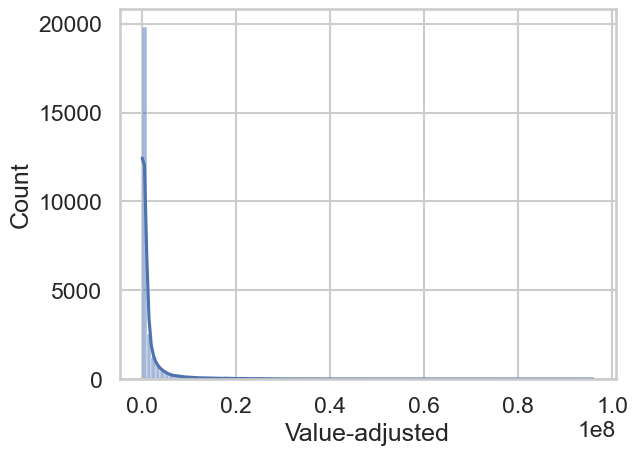

In [16]:
# value adjusted is highly skewed 
sns.histplot(model_data['Value-adjusted'], bins = 100, kde=True, log_scale=False)

<Axes: xlabel='Value-adjusted', ylabel='Count'>

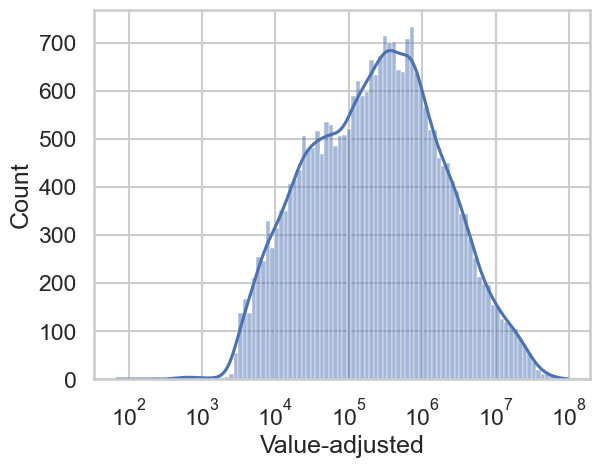

In [17]:
# when log scale applied, data becomes much more normally distributed
sns.histplot(model_data['Value-adjusted'], bins = 100, kde=True, log_scale=True)

In [18]:
model_data

Period  Value-adjusted               GDP-USD
0     2017-05-01    3,023,516.55 19,477,336,549,000.00
1     2017-05-01   24,808,298.71 19,477,336,549,000.00
2     2017-05-01       38,330.44 19,477,336,549,000.00
3     2017-05-01      121,476.42 19,477,336,549,000.00
4     2017-05-01      383,038.25 19,477,336,549,000.00
...          ...             ...                   ...
54047 1990-04-01    7,596,544.89  5,963,144,000,000.00
54048 1990-04-01      967,469.26  5,963,144,000,000.00
54049 1990-04-01        9,460.22  5,963,144,000,000.00
54050 1990-04-01    1,441,995.60  5,963,144,000,000.00
54051 1990-04-01       11,560.25  5,963,144,000,000.00

[26802 rows x 3 columns]

# Facebook Prophet

#### Functions for models

In [19]:
def prophet_prep(df_name):
    df_name = df_name.rename(columns={ df_name.columns[0]: "ds" , df_name.columns[1]:'y'})
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    return df_name

In [20]:
def train_split(df_name, start_year, end_year):
    ''' filters data based on period year for modelling
    '''
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    '''take in true(actual) and predicted values to calculate the MAPE score. 
    MAPE = mean absolute percentage error'''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    result = np.mean(np.abs((y_true - y_pred) / y_true))
    return result

## Model 1: Baseline, only for USA data

* no CV or hyperparams tuning 
* use 1988 to 2008 to train, and predict 2009

### Prepare Data

* Filter for date range
* sum for each day
* Apply log transformation

In [22]:
model_data = prophet_prep(model_data)

In [23]:
model_data

ds             y               GDP-USD
0     2017-05-01  3,023,516.55 19,477,336,549,000.00
1     2017-05-01 24,808,298.71 19,477,336,549,000.00
2     2017-05-01     38,330.44 19,477,336,549,000.00
3     2017-05-01    121,476.42 19,477,336,549,000.00
4     2017-05-01    383,038.25 19,477,336,549,000.00
...          ...           ...                   ...
54047 1990-04-01  7,596,544.89  5,963,144,000,000.00
54048 1990-04-01    967,469.26  5,963,144,000,000.00
54049 1990-04-01      9,460.22  5,963,144,000,000.00
54050 1990-04-01  1,441,995.60  5,963,144,000,000.00
54051 1990-04-01     11,560.25  5,963,144,000,000.00

[26802 rows x 3 columns]

In [24]:
model_data_grouped = model_data.copy()
model_data_grouped = model_data_grouped[['ds', 'y']]
model_data_grouped

ds             y
0     2017-05-01  3,023,516.55
1     2017-05-01 24,808,298.71
2     2017-05-01     38,330.44
3     2017-05-01    121,476.42
4     2017-05-01    383,038.25
...          ...           ...
54047 1990-04-01  7,596,544.89
54048 1990-04-01    967,469.26
54049 1990-04-01      9,460.22
54050 1990-04-01  1,441,995.60
54051 1990-04-01     11,560.25

[26802 rows x 2 columns]

In [25]:
# group by period before taking log 
# group by to have total values by month year
model_data_grouped = model_data_grouped.groupby('ds', as_index=False).sum()
model_data_grouped

ds              y
0   1988-01-01  32,094,345.55
1   1988-02-01  26,852,319.99
2   1988-03-01  34,003,540.09
3   1988-04-01  27,637,080.92
4   1988-05-01  82,665,791.27
..         ...            ...
415 2022-08-01 152,486,864.49
416 2022-09-01 124,696,349.31
417 2022-10-01 118,856,472.23
418 2022-11-01  84,952,911.97
419 2022-12-01 129,159,026.77

[420 rows x 2 columns]

#### scale using log 

<Axes: xlabel='y', ylabel='Count'>

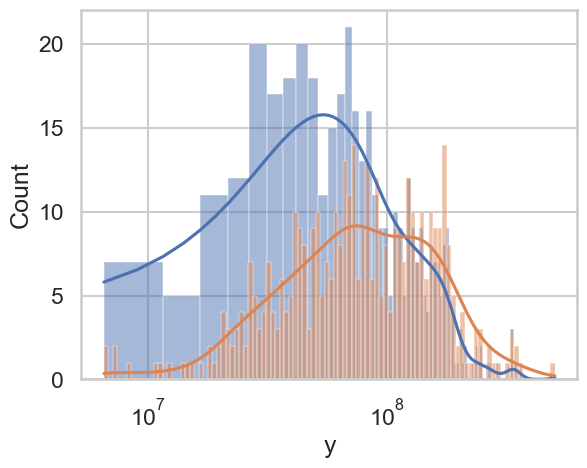

In [26]:
sns.histplot(model_data_grouped['y'], bins = 100, kde=True, log_scale=False)
sns.histplot(model_data_grouped['y'], bins = 100, kde=True, log_scale=True)

In [27]:
# model_data
# apply log transformation
data_log = model_data_grouped.copy()
data_log['y'] = np.log(data_log['y'])
data_log

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
415 2022-08-01 18.84
416 2022-09-01 18.64
417 2022-10-01 18.59
418 2022-11-01 18.26
419 2022-12-01 18.68

[420 rows x 2 columns]

#### Split Test / Train

In [28]:
# create train data set for years 1988 to 2008, will predict year 2009
train_data = train_split(data_log, start_year=1988, end_year=2008)
train_data

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
247 2008-08-01 18.33
248 2008-09-01 18.32
249 2008-10-01 18.11
250 2008-11-01 18.06
251 2008-12-01 18.68

[252 rows x 2 columns]

### Initialise / Run Model

In [29]:
# initialise model, no custom params
m=Prophet()



In [30]:
# fit train data to model
m.fit(train_data)


15:10:30 - cmdstanpy - INFO - Chain [1] start processing
15:10:30 - cmdstanpy - INFO - Chain [1] done processing


### Make and Visualize Predictions 

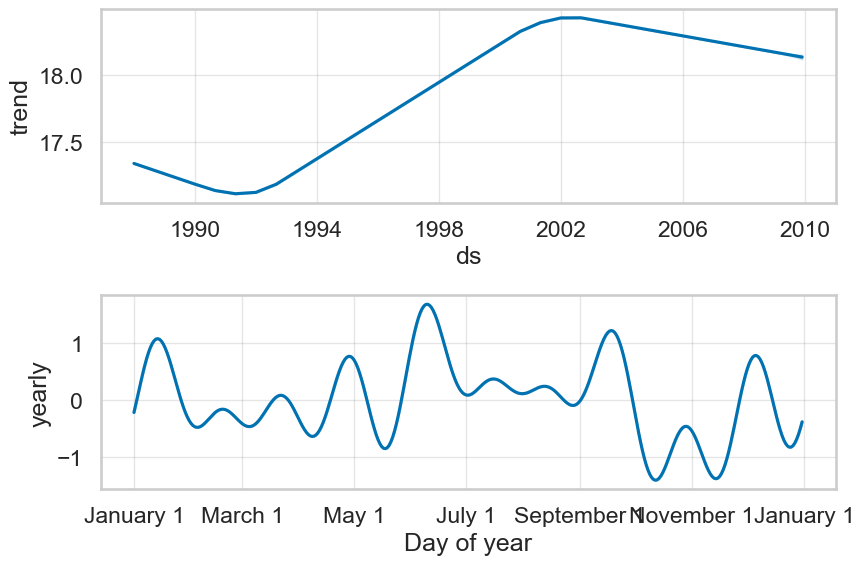

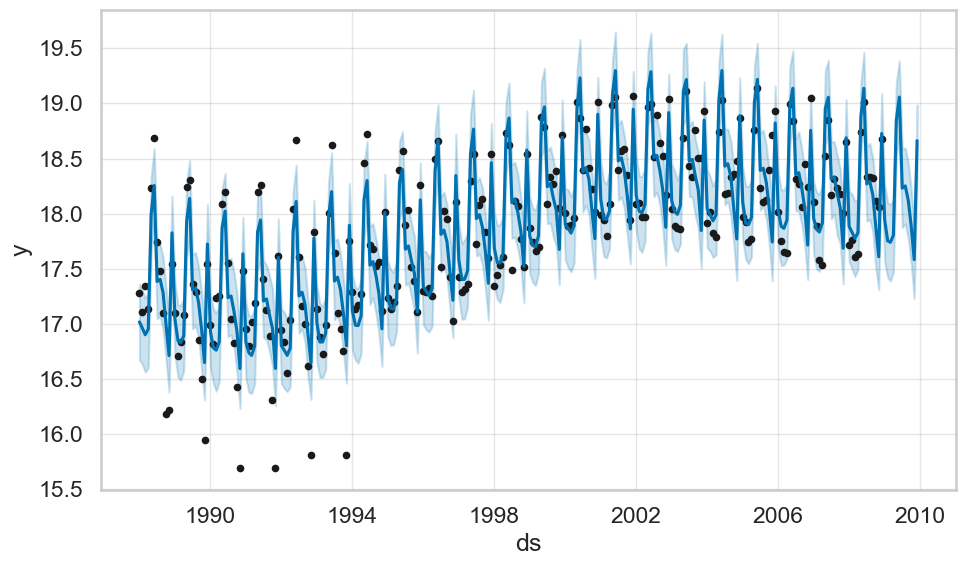

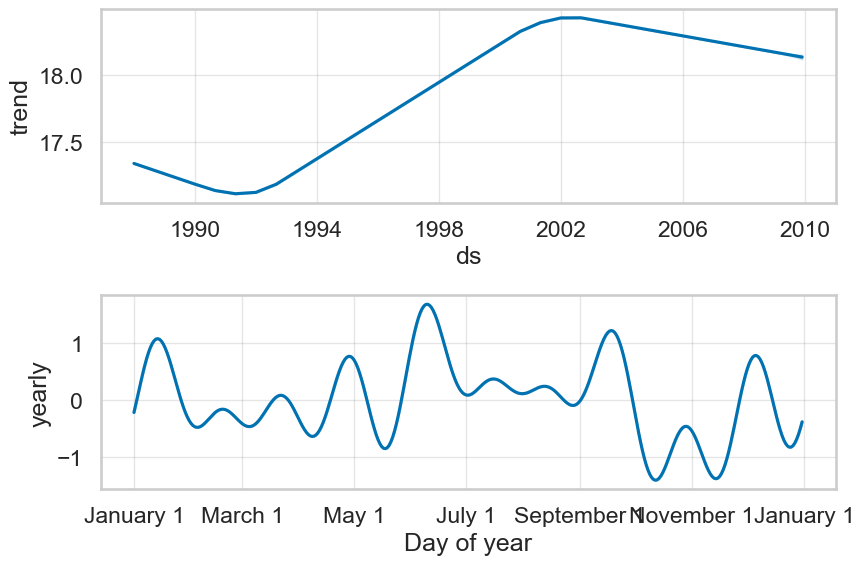

In [31]:
# predict 2009

future = m.make_future_dataframe(periods = 12, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [32]:
forecast = m.predict(future)
preditions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
preditions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.02       16.66       17.35
1   1988-02-01 16.96       16.63       17.27
2   1988-03-01 16.90       16.55       17.24
3   1988-04-01 16.95       16.60       17.29
4   1988-05-01 18.00       17.69       18.37
..         ...   ...         ...         ...
259 2009-08-01 18.25       17.90       18.61
260 2009-09-01 18.12       17.75       18.46
261 2009-10-01 17.89       17.55       18.22
262 2009-11-01 17.58       17.22       17.94
263 2009-12-01 18.66       18.32       18.98

[264 rows x 4 columns]

In [33]:
# get actual values for each period, between 1988 and 2009, values in LOG 
actuals = data_log.loc[data_log['ds'].dt.year <= 2009, ['ds', 'y']].reset_index(drop = True)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

ds  y-actual
0   1988-01-01     17.28
1   1988-02-01     17.11
2   1988-03-01     17.34
3   1988-04-01     17.13
4   1988-05-01     18.23
..         ...       ...
259 2009-08-01     18.11
260 2009-09-01     18.05
261 2009-10-01     17.95
262 2009-11-01     18.04
263 2009-12-01     18.52

[264 rows x 2 columns]

In [34]:
# join actual values and predicted values into one DF
model_eval = preditions.merge(actuals, on='ds', how = 'inner')
model_eval = model_eval.rename(columns={'yhat': 'y-predicted'})
model_eval

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.02       16.66       17.35     17.28
1   1988-02-01        16.96       16.63       17.27     17.11
2   1988-03-01        16.90       16.55       17.24     17.34
3   1988-04-01        16.95       16.60       17.29     17.13
4   1988-05-01        18.00       17.69       18.37     18.23
..         ...          ...         ...         ...       ...
259 2009-08-01        18.25       17.90       18.61     18.11
260 2009-09-01        18.12       17.75       18.46     18.05
261 2009-10-01        17.89       17.55       18.22     17.95
262 2009-11-01        17.58       17.22       17.94     18.04
263 2009-12-01        18.66       18.32       18.98     18.52

[264 rows x 5 columns]

#### Visualise Actuals vs Prediction

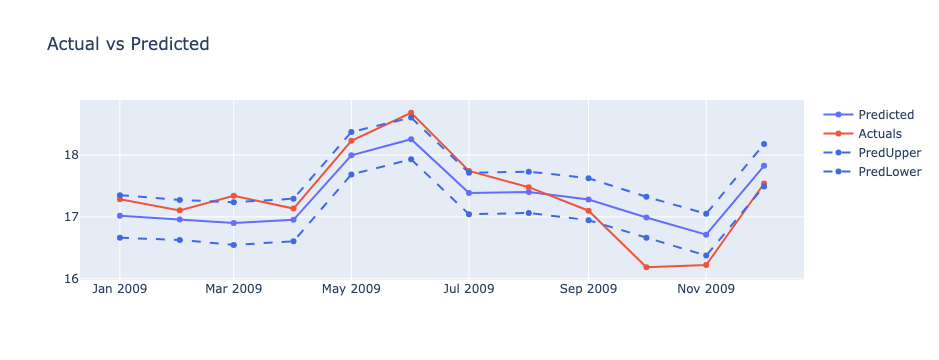

In [35]:
## plot predicted values against actuals, for test range (2009 only)
fig = go.Figure()
preds = model_eval.loc[model_eval['ds'].dt.year >= 2009, :]
x_vals = model_eval.loc[model_eval['ds'].dt.year >= 2009, 'ds']
x_vals

# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['y-actual'], name = 'Actuals'
))

# fig.add_trace(go.Scatter(
#     x=x_vals,
#     y= , name = '', line_color={'dash': 'grey',fill='tonexty'
# ))

fig.add_trace(go.Scatter(x=x_vals, y=model_eval['yhat_upper'], name='PredUpper',
                         line = dict(color='royalblue', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=x_vals, y=model_eval['yhat_lower'], name='PredLower',
                         line = dict(color='royalblue', width=2, dash='dash')))

fig.update_layout(title='Actual vs Predicted')
fig.show()

### Evaluate Model Performance

In [36]:
model_eval

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.02       16.66       17.35     17.28
1   1988-02-01        16.96       16.63       17.27     17.11
2   1988-03-01        16.90       16.55       17.24     17.34
3   1988-04-01        16.95       16.60       17.29     17.13
4   1988-05-01        18.00       17.69       18.37     18.23
..         ...          ...         ...         ...       ...
259 2009-08-01        18.25       17.90       18.61     18.11
260 2009-09-01        18.12       17.75       18.46     18.05
261 2009-10-01        17.89       17.55       18.22     17.95
262 2009-11-01        17.58       17.22       17.94     18.04
263 2009-12-01        18.66       18.32       18.98     18.52

[264 rows x 5 columns]

In [37]:
# return vals to original, take exponent
model_eval_exp = model_eval.copy()
model_eval_exp

ds  y-predicted  yhat_lower  yhat_upper  y-actual
0   1988-01-01        17.02       16.66       17.35     17.28
1   1988-02-01        16.96       16.63       17.27     17.11
2   1988-03-01        16.90       16.55       17.24     17.34
3   1988-04-01        16.95       16.60       17.29     17.13
4   1988-05-01        18.00       17.69       18.37     18.23
..         ...          ...         ...         ...       ...
259 2009-08-01        18.25       17.90       18.61     18.11
260 2009-09-01        18.12       17.75       18.46     18.05
261 2009-10-01        17.89       17.55       18.22     17.95
262 2009-11-01        17.58       17.22       17.94     18.04
263 2009-12-01        18.66       18.32       18.98     18.52

[264 rows x 5 columns]

In [38]:
# return values to original non - log $
model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['y-predicted', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [39]:
model_eval_exp

ds    y-predicted    yhat_lower     yhat_upper       y-actual
0   1988-01-01  24,592,348.72 17,243,343.09  34,340,129.45  32,094,345.55
1   1988-02-01  23,209,519.55 16,649,557.67  31,792,542.00  26,852,319.99
2   1988-03-01  21,897,657.85 15,370,208.73  30,593,195.61  34,003,540.09
3   1988-04-01  23,051,914.69 16,270,116.09  32,428,538.99  27,637,080.92
4   1988-05-01  65,418,040.27 48,015,049.37  95,265,637.68  82,665,791.27
..         ...            ...           ...            ...            ...
259 2009-08-01  84,451,234.94 59,511,297.13 120,749,511.66  73,509,042.15
260 2009-09-01  74,091,976.64 51,354,460.24 104,290,971.32  68,682,796.26
261 2009-10-01  58,693,419.23 41,816,406.15  82,095,158.41  62,222,731.18
262 2009-11-01  43,259,526.35 30,119,681.73  61,779,217.91  68,311,251.76
263 2009-12-01 127,265,026.60 90,526,681.62 174,841,917.03 110,266,803.75

[264 rows x 5 columns]

In [40]:
# df_p = performance_metrics(model_eval_exp)
# df_p

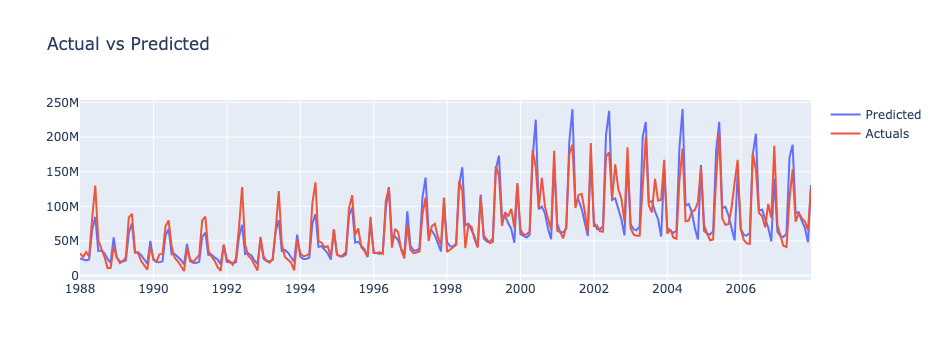

In [41]:
## plot predicted values against actuals for training range (pre-2008)
fig = go.Figure()
preds = model_eval_exp.loc[model_eval_exp['ds'].dt.year < 2008, :]
x_vals = model_eval_exp.loc[model_eval_exp['ds'].dt.year < 2008, 'ds']
x_vals

# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval_exp['y-predicted'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')
fig.show()

In [42]:
## run MSE Only on 2009 test data range
y_actual_test = model_eval_exp.loc[ model_eval_exp['ds'].dt.year > 2008, 'y-actual']
y_pred_test = model_eval_exp.loc[ model_eval_exp['ds'].dt.year > 2008, 'y-predicted']
r2 = r2_score(y_actual_test, y_pred_test)
# print(f'TEST rsquare value is {r2:,.5f}') 
## R SQUARE NOT OK TO USE FOR TIME SERIES

# RMSE

mse = mean_squared_error(y_actual_test, y_pred_test, squared=True)
rmse =  mean_squared_error(y_actual_test, y_pred_test, squared=False)
mape = mean_absolute_percentage_error(y_actual_test, y_pred_test)
print(f'TEST mse value is {mse: ,.2f}')
print(f'TEST rmse value is {rmse : ,.2f}')
print(f'TEST mape value is {mape: ,.5f}')

TEST mse value is  400,193,672,580,040.31
TEST rmse value is  20,004,841.23
TEST mape value is  0.21580


In [43]:
## run MSE Only on 2009 test data range
y_actual = model_eval_exp.loc[ model_eval_exp['ds'].dt.year < 2009, 'y-actual']
y_pred = model_eval_exp.loc[ model_eval_exp['ds'].dt.year < 2009, 'y-predicted']
r2 = r2_score(y_actual, y_pred)
# print(f'TRAIN rsquare value is {r2:,.5f}')
## R SQUARE NOT OK TO USE FOR TIME SERIES

# RMSE

mse = mean_squared_error(y_actual, y_pred, squared=True)
rmse =  mean_squared_error(y_actual, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_actual, y_pred)


print(f'TRAIN mse value is {mse: ,.2f}')
print(f'TRAIN rmse value is {rmse : ,.2f}')
print(f'TRAIN mape value is {mape: ,.5f}')
## slight overfit ???

TRAIN mse value is  384,322,794,250,260.44
TRAIN rmse value is  19,604,152.47
TRAIN mape value is  0.20998


Interpretation:

~* Since the TEST rsquare (.62) is LOWER than TRAIN square (0.82), there is an overfit... model is not generalizing well enough to patterns in data. Model accuracy in training 82%, but in testing drops to 62%?~ WRONG
* Train MAPE is 20.998%, predictions off by 20.998 % on average
* TEST MAPE is only slightly higher, off by 21.5% on average
* Just the baseline model, so can do some param tuning/CV



In [44]:
mape_baseline = mean_absolute_percentage_error(y_actual, y_pred)
print(f'MAPE for baseline model is: {mape_baseline},\n the model predicts with approx {np.abs((1-mape_baseline)*100)}% accuracy ')

MAPE for baseline model is: 0.20997754037846722,
 the model predicts with approx 79.00224596215328% accuracy 


In [45]:
data_log

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
415 2022-08-01 18.84
416 2022-09-01 18.64
417 2022-10-01 18.59
418 2022-11-01 18.26
419 2022-12-01 18.68

[420 rows x 2 columns]

## Model 2a: only for USA data, with CV NO TUNING

### Prepare Data
For this iteration of the model, will use the full time range for the data, in log values, with one observation per day. 

In [46]:
data_log

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
415 2022-08-01 18.84
416 2022-09-01 18.64
417 2022-10-01 18.59
418 2022-11-01 18.26
419 2022-12-01 18.68

[420 rows x 2 columns]

### Initialise / Run Model

In [47]:
# initialise model, no custom params
m=Prophet()

# fit train data to model
m.fit(data_log)

15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:10:56 - cmdstanpy - INFO - Chain [1] done processing


### Make and Visualise Predictions

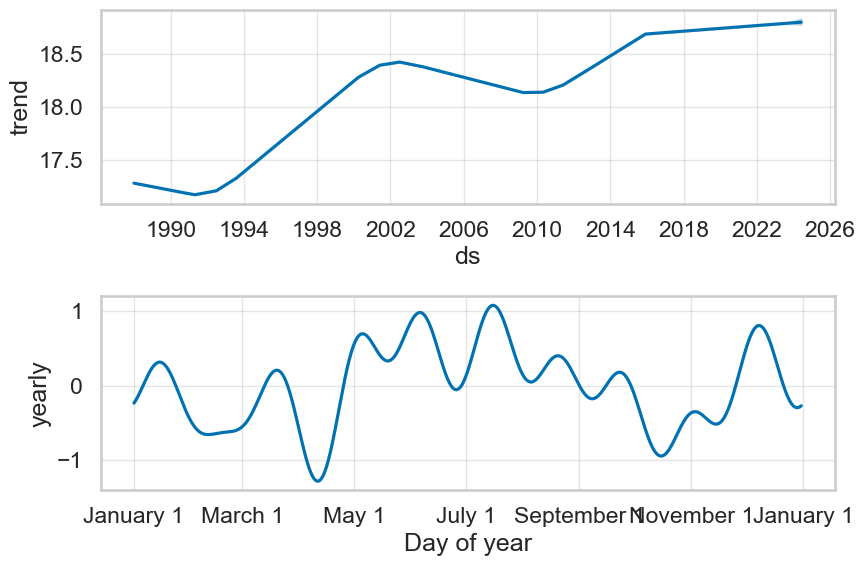

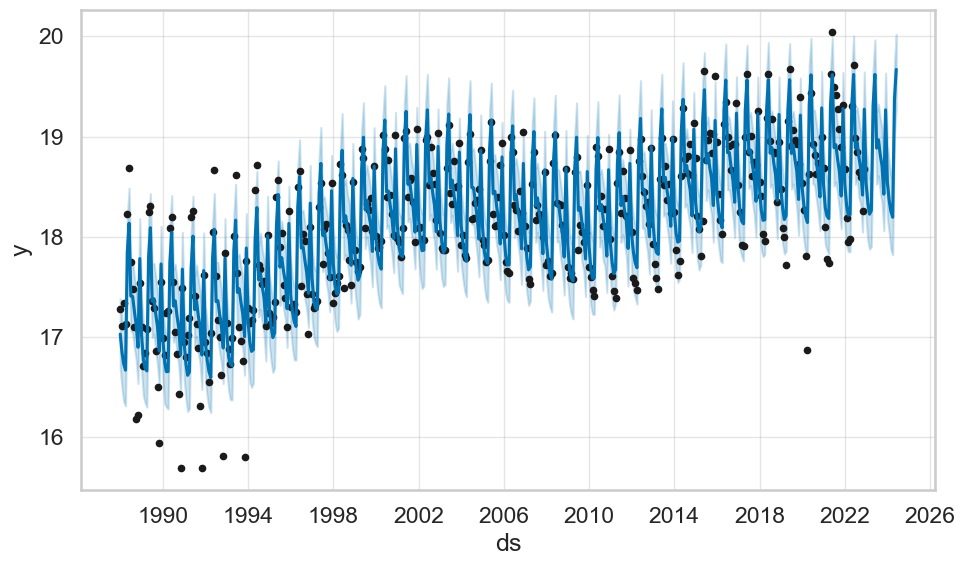

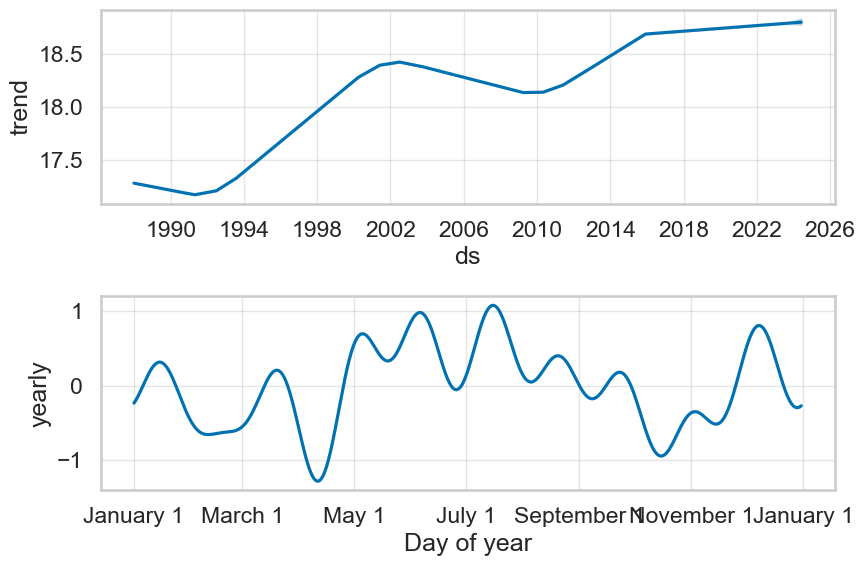

In [48]:
future = m.make_future_dataframe(periods = 18, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [49]:
forecast = m.predict(future)
preditions = forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']]
preditions

df_cv = cross_validation(m, initial='3650 days', period='365 days', horizon = '365 days', parallel="processes")

15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] done processing
15:10:59 - cmdstanpy - INFO - Chain [1] start processing
15:10:59 - cmdstanpy - INFO - Chain [1]

In [50]:
forecast

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   1988-01-01  17.28       16.67       17.40        17.28        17.28   
1   1988-02-01  17.28       16.50       17.22        17.28        17.28   
2   1988-03-01  17.28       16.37       17.12        17.28        17.28   
3   1988-04-01  17.28       16.32       17.02        17.28        17.28   
4   1988-05-01  17.27       17.46       18.22        17.27        17.27   
..         ...    ...         ...         ...          ...          ...   
433 2024-02-01  18.80       17.98       18.73        18.78        18.82   
434 2024-03-01  18.80       17.89       18.62        18.78        18.82   
435 2024-04-01  18.80       17.84       18.56        18.78        18.83   
436 2024-05-01  18.80       19.03       19.75        18.78        18.83   
437 2024-06-01  18.80       19.30       20.04        18.78        18.83   

     additive_terms  additive_terms_lower  additive_terms_upper  yearly  \
0             -0.26                 -0.26                 -0.26   -0.26   
1             -0.44                 -0.44                 -0.44   -0.44   
2             -0.55                 -0.55                 -0.55   -0.55   
3             -0.61                 -0.61                 -0.61   -0.61   
4              0.57                  0.57                  0.57    0.57   
..              ...                   ...                   ...     ...   
433           -0.44                 -0.44                 -0.44   -0.44   
434           -0.55                 -0.55                 -0.55   -0.55   
435           -0.61                 -0.61                 -0.61   -0.61   
436            0.57                  0.57                  0.57    0.57   
437            0.87                  0.87                  0.87    0.87   

     yearly_lower  yearly_upper  multiplicative_terms  \
0           -0.26         -0.26                  0.00   
1           -0.44         -0.44                  0.00   
2           -0.55         -0.55                  0.00   
3           -0.61         -0.61                  0.00   
4            0.57          0.57                  0.00   
..            ...           ...                   ...   
433         -0.44         -0.44                  0.00   
434         -0.55         -0.55                  0.00   
435         -0.61         -0.61                  0.00   
436          0.57          0.57                  0.00   
437          0.87          0.87                  0.00   

     multiplicative_terms_lower  multiplicative_terms_upper  yhat  
0                          0.00                        0.00 17.03  
1                          0.00                        0.00 16.84  
2                          0.00                        0.00 16.73  
3                          0.00                        0.00 16.67  
4                          0.00                        0.00 17.84  
..                          ...                         ...   ...  
433                        0.00                        0.00 18.36  
434                        0.00                        0.00 18.25  
435                        0.00                        0.00 18.19  
436                        0.00                        0.00 19.37  
437                        0.00                        0.00 19.67  

[438 rows x 16 columns]

In [51]:
df_cv.sort_values(by='ds')

ds  yhat  yhat_lower  yhat_upper     y     cutoff
0   1999-01-01 17.76       17.46       18.04 17.87 1998-12-07
1   1999-02-01 17.64       17.33       17.93 17.75 1998-12-07
2   1999-03-01 17.74       17.43       18.02 17.66 1998-12-07
3   1999-04-01 17.91       17.65       18.22 17.69 1998-12-07
4   1999-05-01 18.96       18.66       19.27 18.88 1998-12-07
..         ...   ...         ...         ...   ...        ...
283 2022-08-01 19.06       18.70       19.42 18.84 2021-12-01
284 2022-09-01 18.91       18.55       19.29 18.64 2021-12-01
285 2022-10-01 18.80       18.41       19.17 18.59 2021-12-01
286 2022-11-01 18.54       18.17       18.94 18.26 2021-12-01
287 2022-12-01 19.42       19.03       19.78 18.68 2021-12-01

[288 rows x 6 columns]

In [52]:
preditions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.03       16.67       17.40
1   1988-02-01 16.84       16.50       17.22
2   1988-03-01 16.73       16.37       17.12
3   1988-04-01 16.67       16.32       17.02
4   1988-05-01 17.84       17.46       18.22
..         ...   ...         ...         ...
433 2024-02-01 18.36       17.98       18.73
434 2024-03-01 18.25       17.89       18.62
435 2024-04-01 18.19       17.84       18.56
436 2024-05-01 19.37       19.03       19.75
437 2024-06-01 19.67       19.30       20.04

[438 rows x 4 columns]

In [80]:
df_cv.tail(30)
# df_cv.dtypes

ds  yhat  yhat_lower  yhat_upper     y     cutoff
258 2020-07-01 19.08       18.72       19.42 18.92 2019-12-02
259 2020-08-01 19.11       18.75       19.46 18.82 2019-12-02
260 2020-09-01 18.98       18.62       19.34 18.63 2019-12-02
261 2020-10-01 18.85       18.51       19.20 18.74 2019-12-02
262 2020-11-01 18.62       18.28       19.00 18.63 2019-12-02
263 2020-12-01 19.58       19.20       19.96 19.00 2019-12-02
264 2021-01-01 18.57       18.17       18.93 18.68 2020-12-01
265 2021-02-01 18.37       18.00       18.74 18.10 2020-12-01
266 2021-03-01 18.29       17.94       18.66 17.78 2020-12-01
267 2021-04-01 18.27       17.90       18.61 17.73 2020-12-01
268 2021-05-01 19.38       19.01       19.75 19.62 2020-12-01
269 2021-06-01 19.67       19.30       20.03 20.04 2020-12-01
270 2021-07-01 18.94       18.60       19.30 19.49 2020-12-01
271 2021-08-01 18.98       18.63       19.35 19.42 2020-12-01
272 2021-09-01 18.84       18.50       19.20 19.28 2020-12-01
273 2021-10-01 18.72       18.36       19.07 19.08 2020-12-01
274 2021-11-01 18.48       18.13       18.84 18.89 2020-12-01
275 2021-12-01 19.38       19.00       19.74 19.31 2020-12-01
276 2022-01-01 18.63       18.28       19.00 18.68 2021-12-01
277 2022-02-01 18.42       18.07       18.82 18.19 2021-12-01
278 2022-03-01 18.33       17.95       18.73 17.95 2021-12-01
279 2022-04-01 18.34       17.96       18.72 17.98 2021-12-01
280 2022-05-01 19.42       19.04       19.79 19.30 2021-12-01
281 2022-06-01 19.73       19.36       20.10 19.71 2021-12-01
282 2022-07-01 18.99       18.64       19.38 18.99 2021-12-01
283 2022-08-01 19.06       18.70       19.42 18.84 2021-12-01
284 2022-09-01 18.91       18.55       19.29 18.64 2021-12-01
285 2022-10-01 18.80       18.41       19.17 18.59 2021-12-01
286 2022-11-01 18.54       18.17       18.94 18.26 2021-12-01
287 2022-12-01 19.42       19.03       19.78 18.68 2021-12-01

In [81]:
# preditions.dtypes
preditions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.03       16.67       17.40
1   1988-02-01 16.84       16.50       17.22
2   1988-03-01 16.73       16.37       17.12
3   1988-04-01 16.67       16.32       17.02
4   1988-05-01 17.84       17.46       18.22
..         ...   ...         ...         ...
433 2024-02-01 18.36       17.98       18.73
434 2024-03-01 18.25       17.89       18.62
435 2024-04-01 18.19       17.84       18.56
436 2024-05-01 19.37       19.03       19.75
437 2024-06-01 19.67       19.30       20.04

[438 rows x 4 columns]

In [91]:
# taking copies, attempting to debug
predicted = preditions[['ds','yhat']].copy()
# predicted

actual = df_cv[['ds','y']].copy()
# actual
# # Assuming 'actual' and 'predicted' DataFrames have columns 'ds' and 'yhat'
result_df = pd.merge(predicted[['ds','yhat']], actual[['ds', 'y']], left_on='ds', right_on='ds', how='left')

# # # Display the resulting DataFrame
result_df.tail(50)


ds  yhat     y
388 2020-05-01 19.32 18.62
389 2020-06-01 19.62 19.44
390 2020-07-01 18.89 18.92
391 2020-08-01 18.89 18.82
392 2020-09-01 18.74 18.63
393 2020-10-01 18.62 18.74
394 2020-11-01 18.40 18.63
395 2020-12-01 19.29 19.00
396 2021-01-01 18.53 18.68
397 2021-02-01 18.29 18.10
398 2021-03-01 18.21 17.78
399 2021-04-01 18.18 17.73
400 2021-05-01 19.32 19.62
401 2021-06-01 19.62 20.04
402 2021-07-01 18.89 19.49
403 2021-08-01 18.92 19.42
404 2021-09-01 18.77 19.28
405 2021-10-01 18.65 19.08
406 2021-11-01 18.41 18.89
407 2021-12-01 19.28 19.31
408 2022-01-01 18.53 18.68
409 2022-02-01 18.31 18.19
410 2022-03-01 18.22 17.95
411 2022-04-01 18.22 17.98
412 2022-05-01 19.31 19.30
413 2022-06-01 19.62 19.71
414 2022-07-01 18.89 18.99
415 2022-08-01 18.94 18.84
416 2022-09-01 18.79 18.64
417 2022-10-01 18.68 18.59
418 2022-11-01 18.42 18.26
419 2022-12-01 19.27 18.68
420 2023-01-01 18.54   NaN
421 2023-02-01 18.34   NaN
422 2023-03-01 18.23   NaN
423 2023-04-01 18.26   NaN
424 2023-05-01 19.31   NaN
425 2023-06-01 19.62   NaN
426 2023-07-01 18.88   NaN
427 2023-08-01 18.97   NaN
428 2023-09-01 18.82   NaN
429 2023-10-01 18.71   NaN
430 2023-11-01 18.43   NaN
431 2023-12-01 19.27   NaN
432 2024-01-01 18.54   NaN
433 2024-02-01 18.36   NaN
434 2024-03-01 18.25   NaN
435 2024-04-01 18.19   NaN
436 2024-05-01 19.37   NaN
437 2024-06-01 19.67   NaN

In [89]:
predicted

ds  yhat
0   1988-01-01 17.03
1   1988-02-01 16.84
2   1988-03-01 16.73
3   1988-04-01 16.67
4   1988-05-01 17.84
..         ...   ...
433 2024-02-01 18.36
434 2024-03-01 18.25
435 2024-04-01 18.19
436 2024-05-01 19.37
437 2024-06-01 19.67

[438 rows x 2 columns]

In [84]:
actual

ds     y
0   1999-01-01 17.87
1   1999-02-01 17.75
2   1999-03-01 17.66
3   1999-04-01 17.69
4   1999-05-01 18.88
..         ...   ...
283 2022-08-01 18.84
284 2022-09-01 18.64
285 2022-10-01 18.59
286 2022-11-01 18.26
287 2022-12-01 18.68

[288 rows x 2 columns]

In [58]:
predicted.dtypes

ds      datetime64[ns]
yhat           float64
dtype: object

In [59]:
actual.dtypes

ds    datetime64[ns]
y            float64
dtype: object

#### Visualise Actuals vs Prediction

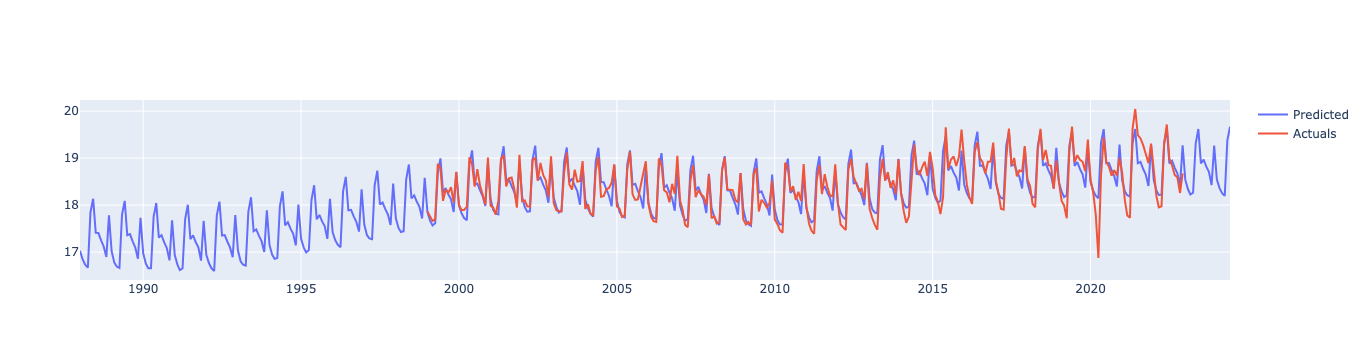

In [92]:
## plot predicted values against actuals,
fig = go.Figure()
# preds = df_cv.loc[model_eval['ds'].dt.year >= 2009, :]
x_vals = result_df['ds']
x_vals

# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals,
    y= result_df['yhat'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals,
    y= result_df['y'], name = 'Actuals'
))

# fig.add_trace(go.Scatter(
#     x=x_vals,
#     y= , name = '', line_color={'dash': 'grey',fill='tonexty'
# ))

# fig.add_trace(go.Scatter(x=x_vals, y=model_eval['yhat_upper'], name='PredUpper',
#                          line = dict(color='royalblue', width=2, dash='dash')))
# fig.add_trace(go.Scatter(x=x_vals, y=model_eval['yhat_lower'], name='PredLower',
#                          line = dict(color='royalblue', width=2, dash='dash')))

# fig.update_layout(title='Actual vs Predicted')
# fig.show()

In [233]:
df_p = performance_metrics(df_cv)
df_p.sort_values(by='coverage', ascending = False)

horizon  mse  rmse  mae  mape  mdape  smape  coverage
4   61 days 0.03  0.16 0.13  0.01   0.01   0.01      0.93
5   62 days 0.03  0.17 0.14  0.01   0.01   0.01      0.93
6   84 days 0.03  0.17 0.14  0.01   0.01   0.01      0.93
2   59 days 0.05  0.22 0.17  0.01   0.01   0.01      0.89
3   60 days 0.04  0.21 0.15  0.01   0.01   0.01      0.89
..      ...  ...   ...  ...   ...    ...    ...       ...
67 334 days 0.25  0.50 0.43  0.02   0.03   0.02      0.43
65 332 days 0.23  0.48 0.41  0.02   0.02   0.02      0.43
68 335 days 0.26  0.51 0.44  0.02   0.03   0.02      0.39
69 359 days 0.26  0.51 0.44  0.02   0.03   0.02      0.39
66 333 days 0.28  0.53 0.47  0.03   0.03   0.03      0.32

[76 rows x 8 columns]

In [234]:
df_p['horizon'].value_counts()

horizon
57 days     1
268 days    1
298 days    1
274 days    1
273 days    1
           ..
149 days    1
148 days    1
147 days    1
146 days    1
365 days    1
Name: count, Length: 76, dtype: int64

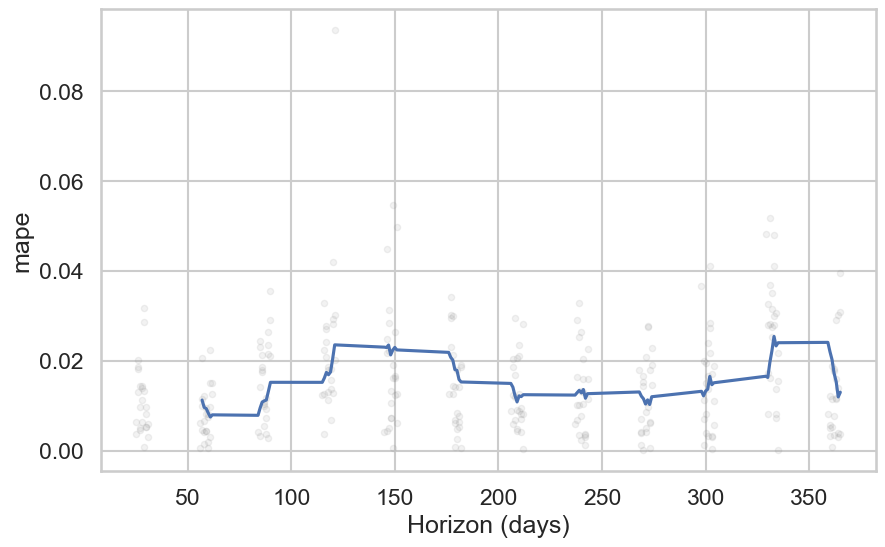

In [126]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

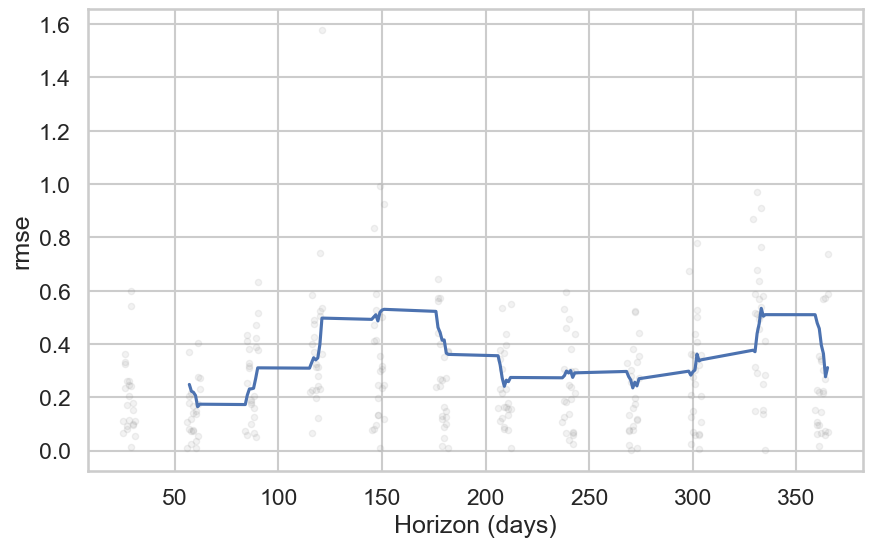

In [127]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

## Model 3: only for USA data, with CV and param tuning

In [108]:
# initialise model, with custom param
m=Prophet()


# fit train data to model, train data same range 
m.fit(train_data)

12:08:33 - cmdstanpy - INFO - Chain [1] start processing
12:08:33 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# df_cv

### Interpretation 
The statistics computed below are:
* mean squared error (MSE), 
* root mean squared error (RMSE), 
* mean absolute error (MAE), 
* mean absolute percent error (MAPE), 
* merdian absolute percent error (MDAPE) 
* and coverage of the yhat_lower and yhat_upper estimates. 

These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). By default 10% of the predictions will be included in each window, but this can be changed with the rolling_window argument.

The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around **1%** are typical for predictions one month into the future, and that errors increase up to around **1%** for predictions that are a year out.


Source: https://facebook.github.io/prophet/docs/diagnostics.html#cross-validation

### now with cv and param tuning

In [110]:
import more_itertools

In [111]:
# cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])

m = Prophet(growth='linear', changepoint_range = changepoint_range, yearly_seasonality = True, weekly_seasonality = True, daily_seasonality = False, seasonality_mode='multiplicative', holidays=holiday)

In [112]:
# initialise model
m=Prophet(seasonality_mode='multiplicative', yearly_seasonality = True, weekly_seasonality = False, daily_seasonality = False,)

In [129]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [5, 10.0, 15.0, 20, 25, 27, 28, 30, 35],
    'seasonality_prior_scale': [0.1, 1.0, 5, 10.0, 15.0, 20, 25, 30],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_log)  # Fit model with given params
    # train on initial 10 years of data, 
    # then after first 10 years, predict one year out every 365 days
    df_cv = cross_validation(m, initial='3650 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=.5)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
# print(tuning_results)


12:27:18 - cmdstanpy - INFO - Chain [1] start processing
12:27:18 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] done processing
12:27:19 - cmdstanpy - INFO - Chain [1] start processing
12:27:19 - cmdstanpy - INFO - Chain [1

In [235]:
tuning_results

changepoint_prior_scale  seasonality_prior_scale  rmse
0                      5.00                     0.10  0.33
1                      5.00                     1.00  0.33
2                      5.00                     5.00  0.33
3                      5.00                    10.00  0.33
4                      5.00                    15.00  0.33
..                      ...                      ...   ...
67                    35.00                    10.00  0.33
68                    35.00                    15.00  0.33
69                    35.00                    20.00  0.33
70                    35.00                    25.00  0.33
71                    35.00                    30.00  0.33

[72 rows x 3 columns]

In [236]:
## Best model params:
# Python
best_params = all_params[np.argmin(rmses)]
print(best_params)
print(f'best params rmse score is {min(rmses)}')

{'changepoint_prior_scale': 28, 'seasonality_prior_scale': 0.1}
best params rmse score is 0.33166526605780644


In [ ]:
## rerun model now with best params? 


In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [5, 10.0, 15.0, 20, 25, 27, 28, 30, 35],
    'seasonality_prior_scale': [0.1, 1.0, 5, 10.0, 15.0, 20, 25, 30],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_log)  # Fit model with given params
    # train on initial 10 years of data, 
    # then after first 10 years, predict one year out every 365 days
    df_cv = cross_validation(m, initial='3650 days', period='365 days', horizon = '365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=.5)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
# print(tuning_results)


## Param Tuning

# Bin

### Model 3a: USD Only no CV, multiple vals per day 

In [ ]:
### backup - make monthly ammounts daily

In [ ]:
m=Prophet()

In [ ]:
model_data = model_data.loc[model_data['ds'].dt.year <= 2008, ['ds', 'y']].reset_index(drop = True)
model_data

In [ ]:
m.fit(model_data)

In [ ]:
future = m.make_future_dataframe(periods = 24, freq="MS")

In [ ]:
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [ ]:
future

In [ ]:
model_data

In [ ]:
actuals = df_value.loc[df_value['ds'].dt.year <= 2011, ['ds', 'y']].reset_index(drop = True)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

In [ ]:
# Python
forecast = m.predict(future)
preditions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



In [ ]:
preditions

In [ ]:
model_eval = preditions.merge(actuals, on='ds', how = 'inner')
model_eval

In [ ]:
x_vals = model_eval['ds']


In [ ]:
## plot predicted values against actuals
import plotly.graph_objects as go

fig = go.Figure()
x_vals = model_eval['ds']

fig = px.line(model_eval, x=x_vals, y='y-actual', title='prediction vs actual')
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['yhat'], name = 'Predicted'
))
fig.show()

In [ ]:
sns.lineplot(data=model_eval[['y-actual', 'yhat']])

In [ ]:





y_actual = model_eval['y-actual']
y_pred = model_eval['yhat']
r2 = r2_score(y_actual, y_pred)
r2

# RMSE
mse = mean_squared_error(y_actual, y_pred)
mse

In [ ]:
# RMSE


mse = mean_squared_error(y_actual, y_pred)
mse

### df_simple

In [ ]:
# import simple clean data
df_simple = pd.read_csv('data/data_simple_clean.csv', index_col=0)
df_simple.head()

In [ ]:
data

In [ ]:
# drop commodity column
df_simple = df_simple.drop(columns=['Commodity'])

In [ ]:
# group by to have total values by month year
df_simple = df_simple.groupby('Period', as_index=False).sum()
df_simple

In [ ]:
df_quantity = df_simple[['Period','Quantity_kg']].copy()
df_quantity

## Model 1 with FB Prophet -Value($) with simple data

In [ ]:
df_simple['Period'] = pd.to_datetime(df_simple['Period'])


In [ ]:
m = Prophet()

In [ ]:
m.fit(df_value)

In [ ]:
future = m.make_future_dataframe(periods = 60, freq="MS")

In [ ]:
future.tail(10)

In [ ]:
forecast = m.predict(future)
fig = m.plot(forecast)

In [ ]:
m.plot_components(forecast)

In [ ]:
# interpretation? 
# seasonality? 
# how long should forecast window be?

## Model 2 FB Prophet with df_simple Value and quantity

In [ ]:
df_simple

In [ ]:
## 

df_simple = df_simple.rename(columns={ df_simple.columns[0]: "ds" , df_simple.columns[1]:'y', df_simple.columns[2]:'quantity_kg'})
df_simple

In [ ]:
m = Prophet()

In [ ]:
# regressor - additional features in df passing into model for training
m.add_regressor('quantity_kg')

In [ ]:
m.fit(df_simple)

In [ ]:
# predict 2 years, 24 months 
future = m.make_future_dataframe(periods = 24, freq="MS")

In [ ]:
len(df_simple)

In [ ]:
df_simple_tail = df_simple.sort_values(by='ds').reset_index(drop=True).tail(24)
df_simple_tail = df_simple_tail.iloc[:,-1]
df_simple_tail

In [ ]:
quantity_feat = pd.DataFrame(pd.concat([df_simple['quantity_kg'], df_simple_tail], axis = 0)).reset_index(drop = True)
quantity_feat

In [ ]:
type(df_simple_tail)

In [ ]:
# type(quantity_feat)
type(future)

In [ ]:
df_pred = pd.concat([future, quantity_feat], axis = 1)
df_pred

In [ ]:
forecast = m.predict(df_pred)
fig = m.plot(forecast)

In [ ]:
forecast

In [ ]:
# yhat actual predicted target value
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
m.plot_components(forecast)

In [ ]:
m.regressor_coefficients(forecast)

### Model 4: USD Only with CV (attempt)

In [ ]:
start_date = df_value['ds'].min().date()

end_date = df_value['ds'].max().date()

cutoffs = pd.date_range(start=start_date, end=end_date, freq='1MS')
print(cutoffs)

In [ ]:
initial= start_date - end_date
initial

In [ ]:
initial

In [ ]:
initial * .7

In [ ]:
initial_train_size

In [ ]:
from prophet.diagnostics import cross_validation, performance_metrics

# Set initial train dataset size (e.g., 80% of the data)
initial_train_size = int(len(df_value) * 0.8)

# Set horizon (e.g., forecast one year into the future)
horizon = '30 days'

# Set period (e.g., spacing between cutoff dates)
period = '180 days'  # Monthly data, so using 30 days as an example


In [ ]:
df_cv = cross_validation(m, initial='{} days'.format(initial_train_size), horizon=horizon)

In [ ]:
# df_cv = cross_validation(model=m, initial='' horizon='365 days', cutoffs=cutoffs)

In [ ]:
m.fit(df_value)

In [ ]:
# 
df_full['Period'] = pd.to_datetime(df_full['Period'])

In [ ]:
df_full.dtypes

In [ ]:
df_value = df_simple[['Period','Value_$']].copy()
df_value

In [ ]:
future = m.make_future_dataframe(periods = 60, freq="MS")

In [ ]:
future

In [ ]:
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

### Model 5: Simple Linear Regression

In [ ]:
model_data

In [ ]:
model_data = model_data.sort_values(by='ds', ascending = True)
model_data

In [ ]:
model_data['ds_ret'] = model_data['ds']